# OVERVIEW

In this second part, as I just said, I will try to improve my results by building different cnn with differet characteristics. As I said before, my main goal is to improve test accuracy, first of all, i perform  data augmentation in order to have more data to train my network; we will see that just doing this stuff improves a lot our results. the details of data augmentation are described in the pdf and in the function dedicated to data aumentation, which is stored in a file call "utils". 



In [2]:
#CELL DEDICATED TO IMPORT PACKAGES USEFULL FOR OUR PURPOSES
import numpy as np
import matplotlib.pyplot as plt
import PIL
from keras.models import Sequential
from keras.layers import Dense
import os
import cv2
from keras.utils import to_categorical
from keras import optimizers
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.callbacks import History
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix

from keras.layers import Conv2D,Flatten,Dropout, MaxPooling2D,AveragePooling2D

import import_ipynb
import utils



Using TensorFlow backend.


importing Jupyter notebook from utils.ipynb


In [3]:
# SOME IMPORTANT GLOBAL VARIABLE
labels = ["Bedroom","Coast","Forest","HighWay","Industrial","InsideCity","Kitchen","LivingRoom","Mountain","Office","OpenCountry","Store","Street","Suburb","TallBuilding"]
train_dir = '../images/train/'
test_dir = '../images/test/'


In [4]:
#creation of  initial data
#train data
list_of_images = utils.list_of_path(labels,train_dir)
train_data,train_labels= utils.read_and_process_images(list_of_images)

#test data
list_of_images_test = utils.list_of_path(labels,test_dir)
test_data,test_labels = utils.read_and_process_images(list_of_images_test)


# DATA AUGMENTATION 

In order to try to achieve a better result, first of all we will try to augment our available data by performing a left-to-right tranformation and cropping. Details of how function "data_augmentation" works are in the presentation paper and in the function

In [17]:
# augmented train data with left-to-right reflection and cropping-->
train_data_aug,train_labels_aug = utils.data_augmentation(train_data,train_labels,cropping=True,crop_y=14,crop_x=14)
test_data_aug, test_labels_aug = utils.data_augmentation(test_data,test_labels,cropping=True,crop_y=14,crop_x=14)

In [18]:
# reshape the data in order to make them feasible 
train_data_aug = train_data_aug.reshape(train_data_aug.shape[0],train_data_aug.shape[1],train_data_aug.shape[2],1)
test_data_aug = test_data_aug.reshape(test_data_aug.shape[0],test_data_aug.shape[1],test_data_aug.shape[2],1)

In [19]:
# create one-note-encoding to make labels feasible for the cnn
test_labels_dummy = to_categorical(test_labels,15)
train_labels_dummy_aug = to_categorical(train_labels_aug,15)
test_labels_dummy_aug = to_categorical(test_labels_aug,15)

# CREATION OF THE CNN 

FIrstly we will try to simply apply the same cnn that we build in the previus part of the exercise and see how the solution gets improved (remember: test_accuracy~0.33)

In [20]:
test_labels_aug.shape

(8955,)

In [21]:
sgd = optimizers.SGD(momentum=0.9,nesterov=True,decay = 1e-6, lr = 0.01)
norm = initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)

In [22]:

model = Sequential()
#first convolutional layer
model.add(Conv2D(filters=8,kernel_size=3,padding = 'valid',activation='relu',input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=2,strides=2))

#secondo convolutional layer
model.add(Conv2D(filters=16,kernel_size=3,strides=2,padding='valid',activation='relu',input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=2,strides=2))

#third convolutional layer
model.add(Conv2D(filters=32,kernel_size=3,padding='valid',activation='relu',input_shape=(64,64,1)))
model.add(Flatten())
model.add(Dense(15,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
model.add(Dense(15,activation='softmax'))

#classification output
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics = ['accuracy'])





In [23]:
history = History()
earlyStopping = EarlyStopping(min_delta=0.10,patience = 10)


model.fit(train_data_aug,train_labels_dummy_aug,batch_size=32,epochs=100,validation_split=0.20,shuffle=True,callbacks=[earlyStopping,history])


Train on 3600 samples, validate on 900 samples
Epoch 1/100
3600/3600 [==============================] - 3s 859us/step - loss: 2.7086 - accuracy: 0.0667 - val_loss: 2.7059 - val_accuracy: 0.0822
Epoch 2/100
3600/3600 [==============================] - 3s 863us/step - loss: 2.7051 - accuracy: 0.0747 - val_loss: 2.6993 - val_accuracy: 0.0756
Epoch 3/100
3600/3600 [==============================] - 3s 833us/step - loss: 2.6921 - accuracy: 0.0942 - val_loss: 2.6783 - val_accuracy: 0.1000
Epoch 4/100
3600/3600 [==============================] - 3s 889us/step - loss: 2.6418 - accuracy: 0.1236 - val_loss: 2.6116 - val_accuracy: 0.1078
Epoch 5/100
3600/3600 [==============================] - 3s 852us/step - loss: 2.4864 - accuracy: 0.1936 - val_loss: 2.3858 - val_accuracy: 0.2456
Epoch 6/100
3600/3600 [==============================] - 3s 811us/step - loss: 2.3117 - accuracy: 0.2528 - val_loss: 2.2567 - val_accuracy: 0.2467
Epoch 7/100
3600/3600 [==============================] - 3s 827us/step 

In [24]:
model.evaluate(test_data_aug,test_labels_dummy_aug)

8955/8955 [==============================] - 3s 356us/step


[2.326505197112884, 0.46845337748527527]

In [34]:
v = model.predict_proba(test_data_aug)
v.shape

(8955, 15)

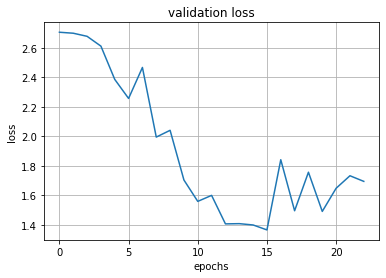

In [166]:
plt.title("validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(history.history['val_loss'])
plt.grid()
plt.savefig("images_point_two/val_loss_data_augmentation_only.jpg")

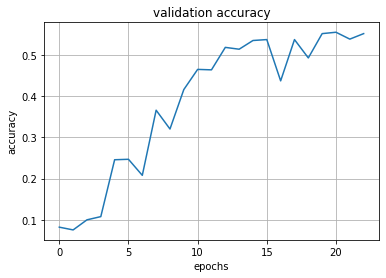

In [167]:
plt.title("validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.savefig("images_point_two/val_acc_data_augmentation_only.jpg")

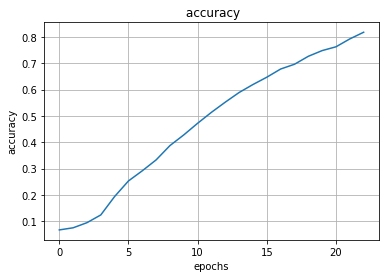

In [168]:
plt.title(" accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history.history['accuracy'])
plt.grid()
plt.savefig("images_point_two/acc_data_augmentation_only.jpg")

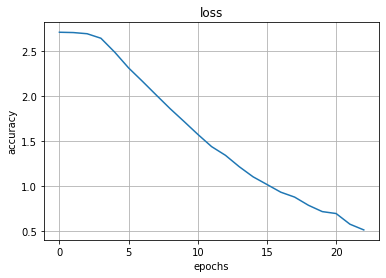

In [169]:
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history.history['loss'])
plt.savefig("images_point_two/loss_data_augmentation_only.jpg")
plt.grid()

In [ ]:
from keras.utils import plot_model
print("My Custom CNN Network:")
plot_model(model, to_file='Images_point_two/custom-cnn.png', show_shapes=True, show_layer_names=True)

## OBSERVATION 

Only with the augmentation of data, we reach a better results in terms of test accuracy (we pass fro 0.33 to 0.44): what to do now? We can try to perform:

-BatchNormalization

-Add Dropout

-Change structure of the CNN, for example by introducing convolutional layer or by changing the size of filters


Our aim is to reach a results better than 0.60

In [170]:
# I wrote a generic function in which I preservre the main structure of the cnn built in the first part of the exercise
#but I add the possibility to add two dropout layer (choosing alse the dropout_rate) and 3 batch layer after performing
#relu 
adam = optimizers.Adam()
def cnn(optim,kernel_sz,batch = False, Drop = False, Dropout_rate = 0):
    np.random.seed(9)
    model = Sequential()
    #first convolutional layer
    model.add(Conv2D(filters=8,kernel_size=kernel_sz,padding = 'valid',activation='relu',input_shape=(64,64,1)))
    if(batch ==True):
        model.add(BatchNormalization(axis = 1))
    model.add(MaxPooling2D(pool_size=2,strides=2))
    if(Drop==True):
        model.add(Dropout(Dropout_rate))

    #secondo convolutional layer
    model.add(Conv2D(filters=16,kernel_size=kernel_sz,strides=2,padding='valid',activation='relu',input_shape=(64,64,1)))
    if(batch==True):
        model.add(BatchNormalization(axis = 1))
    model.add(MaxPooling2D(pool_size=2,strides=2))
    if(Drop==True):
        model.add(Dropout(Dropout_rate))

    #third convolutional layer
    model.add(Conv2D(filters=32,kernel_size=kernel_sz,padding='valid',activation='relu',input_shape=(64,64,1)))
    model.add(Flatten())
    model.add(Dense(15,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
    if(batch==True):
        model.add(BatchNormalization(axis = 1))
    model.add(Dense(15,activation='softmax'))

    #classification output
    model.compile(loss='categorical_crossentropy',optimizer= optim,metrics = ['accuracy'])
    return model


def cnn_2():
    np.random.seed(9)
    model = Sequential()
    #first convolutional layer
    model.add(Conv2D(filters=8,kernel_size=(3,3),padding = 'valid',activation='relu',input_shape=(64,64,1)))
    
    model.add(BatchNormalization(axis = 1))
    model.add(MaxPooling2D(pool_size=2,strides=2))
    
    model.add(Dropout(0.3))

    #secondo convolutional layer
    model.add(Conv2D(filters=16,kernel_size=(3,3),strides=2,padding='valid',activation='relu',input_shape=(64,64,1)))
   
    model.add(BatchNormalization(axis = 1))
    model.add(MaxPooling2D(pool_size=2,strides=2))
    
    model.add(Dropout(0.3))

    #third convolutional layer
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(64,64,1)))
    model.add(Flatten())
    model.add(Dense(15,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
    
    model.add(BatchNormalization(axis = 1))
    model.add(Dense(15,activation='softmax'))

    #classification output
    model.compile(loss='categorical_crossentropy',optimizer= adam,metrics = ['accuracy'])
    return model
    
    

In [172]:
#model_2: respect to the originale model, I just add dropout (with rate 0.5) and batchnormalization 
model_2 = cnn(adam,3,batch=True,Drop=True,Dropout_rate=0.5)

In [173]:

history_2 = History()
earlyStopping_2 = EarlyStopping(min_delta=0.10,patience = 10)


model_2.fit(train_data_aug,train_labels_dummy_aug,batch_size=32,epochs=100,validation_split=0.20,shuffle=True,callbacks=[earlyStopping_2,history_2])


Train on 3600 samples, validate on 900 samples
Epoch 1/100
3600/3600 [==============================] - 8s 2ms/step - loss: 2.5544 - accuracy: 0.1753 - val_loss: 3.3039 - val_accuracy: 0.0689
Epoch 2/100
3600/3600 [==============================] - 6s 2ms/step - loss: 2.2452 - accuracy: 0.2633 - val_loss: 5.3880 - val_accuracy: 0.0689
Epoch 3/100
3600/3600 [==============================] - 6s 2ms/step - loss: 2.0759 - accuracy: 0.3289 - val_loss: 5.6557 - val_accuracy: 0.0689
Epoch 4/100
3600/3600 [==============================] - 7s 2ms/step - loss: 1.9360 - accuracy: 0.3589 - val_loss: 5.5642 - val_accuracy: 0.0689
Epoch 5/100
3600/3600 [==============================] - 7s 2ms/step - loss: 1.7932 - accuracy: 0.4078 - val_loss: 3.3317 - val_accuracy: 0.1211
Epoch 6/100
3600/3600 [==============================] - 7s 2ms/step - loss: 1.7131 - accuracy: 0.4292 - val_loss: 2.8719 - val_accuracy: 0.1733
Epoch 7/100
3600/3600 [==============================] - 8s 2ms/step - loss: 1.6443

In [175]:
 model_2.evaluate(test_data_aug,test_labels_dummy_aug)

8955/8955 [==============================] - 4s 488us/step


[1.3994566063186031, 0.5670574903488159]

In [ ]:
plot_model(model_2, to_file='Images_point_two/cnn-dropout-batch.png', show_shapes=True, show_layer_names=True)

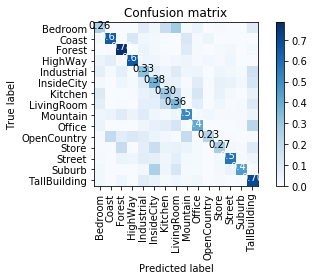

In [182]:
# cofunsion matrix of model with batch normalization and dropout 
y_pred = model.predict_classes(test_data_aug)
cm = confusion_matrix(test_labels_aug,y_pred)
utils.plot_confusion_matrix(cm,labels,"point_two_dropout_batch_cm","images_point_two/",normalize=True)

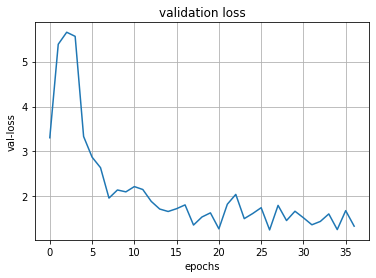

In [178]:
plt.title("validation loss")
plt.xlabel("epochs")
plt.ylabel("val-loss")
plt.plot(history_2.history['val_loss'])
plt.grid()
plt.savefig("images_point_two/validation_loss_dropout_batch.jpg")

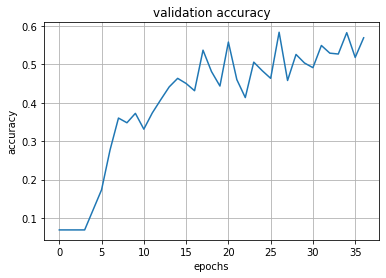

In [179]:
plt.title("validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history_2.history['val_accuracy'])
plt.grid()
plt.savefig("images_point_two/validation_accuracy_dropout_batch.jpg")

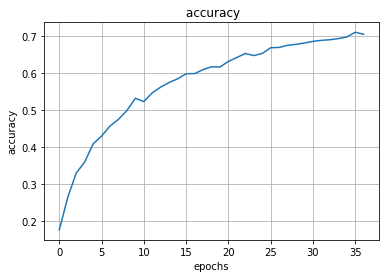

In [180]:
plt.title(" accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history_2.history['accuracy'])
plt.grid()
plt.savefig("images_point_two/accuracy_dropout_batch.jpg")

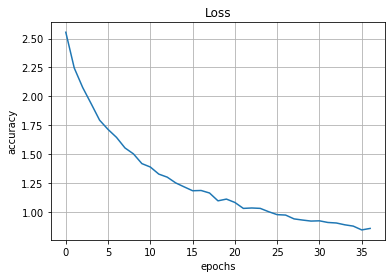

In [181]:
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history_2.history['loss'])
plt.grid()
plt.savefig("images_point_two/loss_dropout_batch.jpg")

In [ ]:
#change onglu the size of the kernels--> structures are always the same as the first convolutional network 
model_3 = cnn(adam,5,batch=True,Drop=True,Dropout_rate=0.3)

In [ ]:
history_3 = History()
earlyStopping_3 = EarlyStopping(min_delta=0.10,patience = 10)
model_3.fit(train_data_aug,train_labels_dummy_aug,batch_size=32,epochs=100,validation_split=0.15,shuffle=True,callbacks=[earlyStopping_3,history_3])


In [ ]:
model_3.evaluate(test_data_aug,test_labels_dummy_aug)


In [ ]:
plot_model(model_3,show_shapes=True, show_layer_names=True)

# ENSEMBLE OF NETWORK 

In the following cells I wrote two functions in order to perform the so called "ensemble of network".

-In the first function I train n times a cnn and I perform a prediction on test data in terms of probabilistic distribution along the 15 different classes.

-In the second class I perform the mean along the different obtained results

In [136]:

def ensemble_of_network(mod,iteration,train_data, train_labels,test_data):
    history = History()
    earlyStopping = EarlyStopping(min_delta=0.10,patience = 10)
    prediction = np.zeros((test_data.shape[0],15))
    loss = []
    validation_loss = []
    validation_acc = []
    acc = []
    pred_voting = []
    for i in range(iteration):
        model_temp = mod()
        model_temp.fit(train_data,train_labels,batch_size=32,epochs=100,validation_split=0.15,shuffle=True,callbacks=[earlyStopping,history])
        prediction = prediction + model_temp.predict_proba(test_data)
        pred_voting.append(model_temp.predict_classes(test_data))
        loss.append(history.history['loss'])
        validation_loss.append(history.history['val_loss'])
        validation_acc.append(history.history['val_accuracy'])
        acc.append(history.history['accuracy'])
    
    prediction = prediction/iteration
    
    return prediction,pred_voting,validation_acc,acc,validation_loss,loss
    
        
def calculate_accuracy(prediction,test_labels):
    total = test_labels.shape[0]
    cont = 0
    for i in range(len(prediction)):
        if(np.argmax(prediction[i])==test_labels[i]):
            cont = cont + 1
        else: 
            
            
            continue 
    res = cont/total
    return res 

##################################################################################
def determ_prediction(pred,test_lab):
    res = np.zeros(len(pred[0]))
    for i in range(len(pred[0])):
        cont = np.zeros(15)
        #viaggio per le immagini
        for j in range(len(pred)):
            #viaggio per i tentativi di cnn
            
            cont[pred[j][i]]+=1
        
        maxi = np.argmax(cont)
        res[i] = maxi
        
    return res
    

def calulate_accuracy_with_voting(pred,test_labels):
    total = test_labels.shape[0]
    cont = 0
    for i in range(len(pred)):
        if(pred[i]==test_labels[i]):
            cont = cont +1
        else:
            continue
    res = cont/total
    return res
        
# il VOTING FA SCHIFO AHAAHAHAHAHAAHAHAHA FORSE HO SBAGLIATO QUALCOSA NEL CODICE, MA NON PENSO 

In [129]:
pred,pred_vot,val_acc,val,val_loss,loss = ensemble_of_network(cnn_2,10,train_data_aug,train_labels_dummy_aug,test_data_aug)


Train on 3825 samples, validate on 675 samples
Epoch 1/100
3825/3825 [==============================] - 7s 2ms/step - loss: 2.5821 - accuracy: 0.1605 - val_loss: 3.2186 - val_accuracy: 0.0607
Epoch 2/100
3825/3825 [==============================] - 6s 2ms/step - loss: 2.2877 - accuracy: 0.2664 - val_loss: 3.1362 - val_accuracy: 0.0859
Epoch 3/100
3825/3825 [==============================] - 7s 2ms/step - loss: 2.0704 - accuracy: 0.3388 - val_loss: 3.0570 - val_accuracy: 0.0874
Epoch 4/100
3825/3825 [==============================] - 7s 2ms/step - loss: 1.9170 - accuracy: 0.3888 - val_loss: 2.5254 - val_accuracy: 0.1881
Epoch 5/100
3825/3825 [==============================] - 6s 2ms/step - loss: 1.7866 - accuracy: 0.4282 - val_loss: 1.9498 - val_accuracy: 0.3156
Epoch 6/100
3825/3825 [==============================] - 7s 2ms/step - loss: 1.6409 - accuracy: 0.4654 - val_loss: 2.5380 - val_accuracy: 0.2430
Epoch 7/100
3825/3825 [==============================] - 7s 2ms/step - loss: 1.5497

3825/3825 [==============================] - 7s 2ms/step - loss: 0.9945 - accuracy: 0.6570 - val_loss: 1.3240 - val_accuracy: 0.5511
Epoch 17/100
3825/3825 [==============================] - 7s 2ms/step - loss: 0.9491 - accuracy: 0.6769 - val_loss: 1.2165 - val_accuracy: 0.6000
Epoch 18/100
3825/3825 [==============================] - 7s 2ms/step - loss: 0.9078 - accuracy: 0.6865 - val_loss: 1.1256 - val_accuracy: 0.6341
Epoch 19/100
3825/3825 [==============================] - 7s 2ms/step - loss: 0.9137 - accuracy: 0.6831 - val_loss: 1.0715 - val_accuracy: 0.6356
Epoch 20/100
3825/3825 [==============================] - 7s 2ms/step - loss: 0.8887 - accuracy: 0.6884 - val_loss: 1.1150 - val_accuracy: 0.6074
Epoch 21/100
3825/3825 [==============================] - 6s 2ms/step - loss: 0.8633 - accuracy: 0.7108 - val_loss: 1.0468 - val_accuracy: 0.6504
Epoch 22/100
3825/3825 [==============================] - 7s 2ms/step - loss: 0.8392 - accuracy: 0.7124 - val_loss: 1.2020 - val_accuracy

Epoch 16/100
3825/3825 [==============================] - 6s 2ms/step - loss: 0.9119 - accuracy: 0.6847 - val_loss: 1.2043 - val_accuracy: 0.5985
Epoch 17/100
3825/3825 [==============================] - 6s 2ms/step - loss: 0.8655 - accuracy: 0.7093 - val_loss: 1.2890 - val_accuracy: 0.5748
Epoch 18/100
3825/3825 [==============================] - 6s 1ms/step - loss: 0.8456 - accuracy: 0.7108 - val_loss: 1.1483 - val_accuracy: 0.5956
Epoch 19/100
3825/3825 [==============================] - 6s 2ms/step - loss: 0.8388 - accuracy: 0.7158 - val_loss: 1.1046 - val_accuracy: 0.6207
Epoch 20/100
3825/3825 [==============================] - 6s 2ms/step - loss: 0.8175 - accuracy: 0.7252 - val_loss: 1.0643 - val_accuracy: 0.6326
Epoch 21/100
3825/3825 [==============================] - 6s 2ms/step - loss: 0.7829 - accuracy: 0.7331 - val_loss: 1.3408 - val_accuracy: 0.5481
Epoch 22/100
3825/3825 [==============================] - 6s 2ms/step - loss: 0.7730 - accuracy: 0.7339 - val_loss: 1.0392 -

Epoch 10/100
3825/3825 [==============================] - 6s 1ms/step - loss: 1.0654 - accuracy: 0.6416 - val_loss: 1.1558 - val_accuracy: 0.5926
Epoch 11/100
3825/3825 [==============================] - 6s 1ms/step - loss: 1.0037 - accuracy: 0.6635 - val_loss: 1.1512 - val_accuracy: 0.6104
Epoch 12/100
3825/3825 [==============================] - 6s 1ms/step - loss: 0.9978 - accuracy: 0.6617 - val_loss: 1.4240 - val_accuracy: 0.5333
Epoch 13/100
3825/3825 [==============================] - 6s 1ms/step - loss: 0.9419 - accuracy: 0.6839 - val_loss: 1.1444 - val_accuracy: 0.6059
Epoch 14/100
3825/3825 [==============================] - 6s 1ms/step - loss: 0.8968 - accuracy: 0.6944 - val_loss: 1.1229 - val_accuracy: 0.5956
Epoch 15/100
3825/3825 [==============================] - 5s 1ms/step - loss: 0.8877 - accuracy: 0.7012 - val_loss: 1.1024 - val_accuracy: 0.6296
Epoch 16/100
3825/3825 [==============================] - 6s 1ms/step - loss: 0.8501 - accuracy: 0.7174 - val_loss: 1.3340 -

In [132]:
calculate_accuracy(pred,test_labels_aug)

0.6457844779452819

10

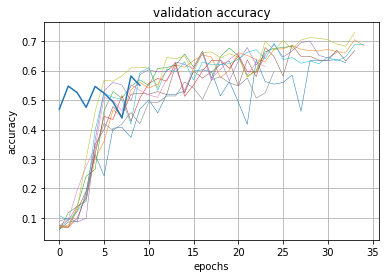

In [199]:
plt.title("validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
for p in val_acc:
    plt.plot(p,linewidth=0.5)
plt.plot(mean_val_acc,linewidth=1.5)
plt.grid()

In [1]:
plt.title("accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
for p in val:
    plt.plot(p,linewidth=0.5)
plt.grid()

NameError: name 'plt' is not defined

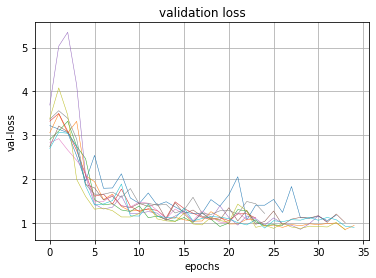

In [148]:
plt.title("validation loss")
plt.xlabel("epochs")
plt.ylabel("val-loss")
for p in val_loss:
    plt.plot(p,linewidth=0.5)
plt.grid()

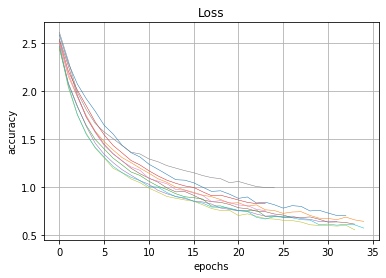

In [150]:
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("accuracy")
for p in loss:
    plt.plot(p,linewidth=0.5)
plt.grid()

In [137]:
res = determ_prediction(pred_vot,test_labels_aug)


In [138]:
acc = calulate_accuracy_with_voting(res,test_labels_aug)


In [139]:
acc

0.6366275823562255

# play with number of layers

In [161]:
np.random.seed(9)
model_4 = Sequential()
#first convolutional layer
model_4.add(Conv2D(filters=8,kernel_size=(3,3),strides = 1,padding = 'valid',activation='relu',input_shape=(64,64,1)))
model_4.add(BatchNormalization(axis=1))
model_4.add(MaxPooling2D(pool_size=2,strides=2))
model_4.add(Dropout(0.3))

#secondo convolutional layer
model_4.add(Conv2D(filters=16,kernel_size=(3,3),strides=1,padding='valid',activation='relu',input_shape=(64,64,1)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))
#third convolutional layer
model_4.add(Conv2D(filters=32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(64,64,1)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

#add 1 convolutional layer
model_4.add(Conv2D(filters=64,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(64,64,1)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=2,strides=2))
model_4.add(Dropout(0.3))

#for now I just add another maxpooling
model_4.add(Flatten())
#add 1 dense layer

model_4.add(Dense(30,activation='relu',kernel_initializer=norm,bias_initializer='zeros'))
model_4.add(BatchNormalization())
model_4.add(Dense(15,activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dense(15,activation='softmax'))

#classification output
model_4.compile(loss='categorical_crossentropy',optimizer= adam,metrics = ['accuracy'])

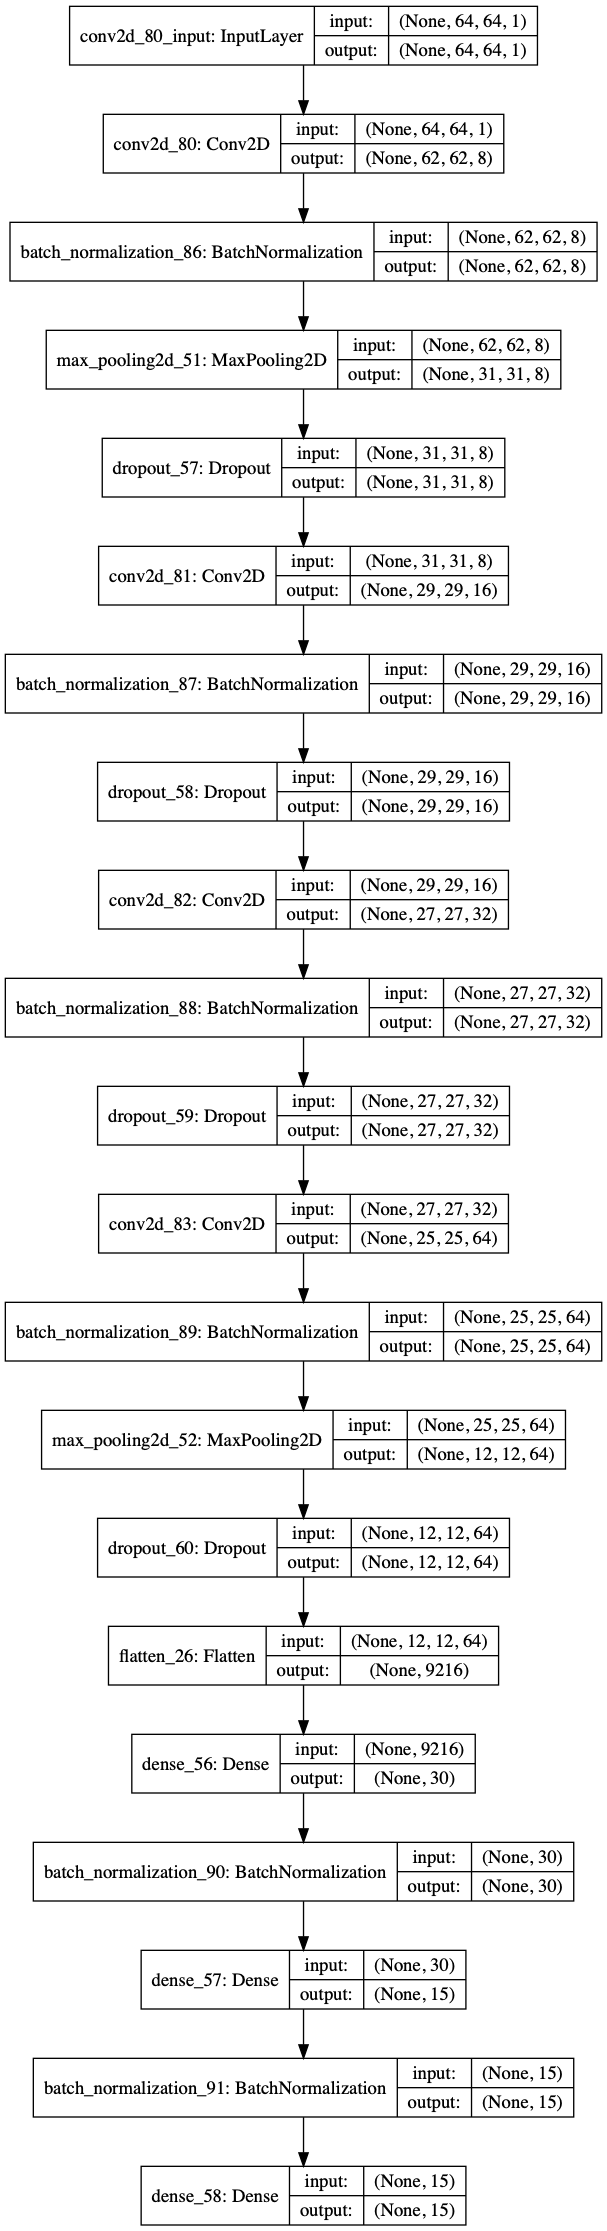

In [162]:
plot_model(model_4,show_shapes=True, show_layer_names=True)

In [163]:
history_4 = History()
earlyStopping_4 = EarlyStopping(min_delta=0.10,patience = 10)
model_4.fit(train_data_aug,train_labels_dummy_aug,batch_size=32,epochs=100,validation_split=0.15,shuffle=True,callbacks=[earlyStopping_4,history_4])


Train on 3825 samples, validate on 675 samples
Epoch 1/100
3825/3825 [==============================] - 36s 9ms/step - loss: 2.5120 - accuracy: 0.1898 - val_loss: 4.6641 - val_accuracy: 0.0919
Epoch 2/100
3825/3825 [==============================] - 27s 7ms/step - loss: 2.0453 - accuracy: 0.3292 - val_loss: 48.7568 - val_accuracy: 0.0741
Epoch 3/100
3825/3825 [==============================] - 26s 7ms/step - loss: 1.7367 - accuracy: 0.4335 - val_loss: 6.8124 - val_accuracy: 0.1304
Epoch 4/100
3825/3825 [==============================] - 29s 8ms/step - loss: 1.5439 - accuracy: 0.4897 - val_loss: 4.0312 - val_accuracy: 0.1630
Epoch 5/100
3825/3825 [==============================] - 28s 7ms/step - loss: 1.3308 - accuracy: 0.5681 - val_loss: 30.0620 - val_accuracy: 0.1407
Epoch 6/100
3825/3825 [==============================] - 27s 7ms/step - loss: 1.1783 - accuracy: 0.6086 - val_loss: 29.5906 - val_accuracy: 0.2741
Epoch 7/100
3825/3825 [==============================] - 29s 7ms/step - lo

In [164]:
model_4.evaluate(test_data_aug,test_labels_dummy_aug)

8955/8955 [==============================] - 14s 2ms/step


[1.856033660365775, 0.5686208605766296]